In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("HW3.ipynb")

### Grading
The final score that you will receive for your programming assignment is generated in relation to the total points set in your programming assignment item—not the total point value in the autograder output.     
Autograded quesions may have hidden tests and/or public tests. You can see the public test results when you run the notebook with otter grader. Usually public tests are for simple checks (such as variable types) and may not indicate that the answer is correct.     
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** The autograder will not work properly if your change the variable or method signatures. 

# K-nearest neighbors

Run the cell below to ensure that the required packages are imported.

In [3]:
import math
import pickle
import gzip
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# importing all the required libraries

from math import exp
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import BallTree
from numpy import loadtxt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### Problem 1 : Building a K- Nearest neighbours classifier for handwritten digit recognition [30 pts]
In this problem you will complete some code to build a k-nearest neighbour classifier to classify images of handwritten digits (0-9). For this purpose we will use a famous open-source dataset of handwritten digits called the MNIST that is ubiquitously used for testing a number of classification algorithms in machine learning.

In [4]:
# This cell sets up the MNIST dataset 

class MNIST_import:
    """
    sets up MNIST dataset from OpenML 
    """
    def __init__(self):
        
        df = pd.read_csv("data/mnist_784.csv")
        
        # Create arrays for the features and the response variable
        # store for use later 
        y = df['class'].values
        X = df.drop('class', axis=1).values
         
        # Convert the labels to numeric labels
        y = np.array(pd.to_numeric(y))
        
        # create training and validation sets 
        self.train_x, self.train_y = X[:5000,:], y[:5000]
        self.val_x, self.val_y = X[5000:6000,:], y[5000:6000]
        
data = MNIST_import()

In [5]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(28,28), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

Display a particular digit using the above function:

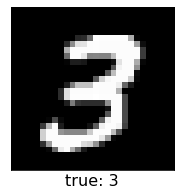

In [6]:
training_index = 7

view_digit(data.train_x[training_index], data.train_y[training_index])


**Part 1.A [5 points]**
Fill in the code in the following cell to determine the following quantities:
   - Number of pixels in each image
   - Number of examples in the training set
   - Number of examples in the test set
   

In [7]:
# Here are the numbers you need to provide here:
num_training_examples = len(data.train_x)
num_test_examples = len(data.val_x)
pixels_per_image = len(data.train_x[0])


print(num_training_examples)
print(num_test_examples)
print(pixels_per_image)
# print(data.train_x.shape)
# print(data.train_x[0])

5000
1000
784


Now that we have our MNIST data in the right form, let us move on to building our KNN classifier.

**Part 1.B [10 points]**: Modify the class above to implement a KNN classifier.  There are three methods that you need to complete: 

- `predict`: Given an $m \times p$ matrix of validation data with $m$ examples each with $p$ features, return a length-$m$ vector of predicted labels by calling the `classify` function on each example. 
- `classify`: Given a single query example with $p$ features, return its predicted class label as an integer using KNN by calling the `majority` function. 
- `majority`: Given an array of indices into the training set corresponding to the $K$ training examples that are nearest to the query point, return the majority label as an integer.  If there is a tie for the majority label using $K$ nearest neighbors, reduce $K$ by 1 and try again.  Continue reducing $K$ until there is a winning label. 

**Notes**: 
- Do not nearest-neighbor search or any distance metrics yourself. Instead, read the documentation for Scikit-Learn's [BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) object.  You will find that its implemented [query](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree.query) method can do most of the heavy lifting for you. 
- Do not use Scikit-Learn's KNeighborsClassifier in this problem.  We're implementing this ourselves using BallTree.
- For more information about different algorithms under the K-nearest neighbors and which algorithms are being used by sklearn in different scenarios, please see User guide p.263.

In [8]:
class KNN:
    """
    Class to store data for regression problems 
    """
    def __init__(self, x_train, y_train, K=5):
        """
        Creates a kNN instance

        :param x_train: numpy array with shape (n_rows,1)- e.g. [[1,2],[3,4]]
        :param y_train: numpy array with shape (n_rows,)- e.g. [1,-1]
        :param K: The number of nearest points to consider in classification
        """
        
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(x_train)
        
        # Cache training labels and parameter K 
        self.x_train = x_train
        self.y_train = y_train
        self.K = K


    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        map = {}
        for i in range(0, len(neighbor_indices)):
            if neighbor_indices[i] in map.keys():
                map[neighbor_indices[i]] += 1
            else:
                map[neighbor_indices[i]] = 1       
        for key in map:
            if map[key] > (len(neighbor_indices) / 2):
                return key
        return self.majority(neighbor_indices[: -1])
            


        
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        ball tree. 
        :param x: a query point stored as an ndarray  
        """
        ind_to_label = []
        labels = self.y_train
        dist, ind = self.balltree.query([x], k=self.K)
        flat_list = [item for sublist in ind for item in sublist]
        for i in range(0,len(flat_list)):
            ind_to_label.append(labels[flat_list[i]])
        answer = self.majority(ind_to_label)
        return answer
        
        
    def predict(self, X):
        """
        Given an ndarray of query points, return yhat, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        predict_label = np.array([self.classify(x) for x in X])
        return predict_label

In [9]:
# data.train_x[361]

In [10]:
knn = KNN(data.train_x, data.train_y, 10)

print(knn.predict(data.val_x[0:1,:]))
# test = knn.predict(data.val_x[0:10,:])
# print("shape", test.shape)
# print(test)

[7]


<!-- BEGIN QUESTION -->

**Part 1.C : Checking how well your classifier does [5 pts]**    
Use your `KNN` class to perform KNN on the validation data with $K=3$ and do the following: 

1. Create a **confusion matrix** and display the results (Hont: Feel free to use the Scikit-Learn [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function).

2. Based on your confusion matrix, which digits seem to get confused with other digits the most? 

In [11]:
# use your KNN class to perform KNN on the validation data with K = 3
knn = KNN(data.train_x, data.train_y, 25)
val_yhat = knn.predict(data.val_x)
score = accuracy_score(data.val_y, val_yhat)
# create a confusion matrix 
cm = confusion_matrix(data.val_y, val_yhat)
print(cm)
print(score)

[[111   0   0   0   1   0   1   0   0   0]
 [  0 106   0   0   0   0   0   1   0   1]
 [  2   6  82   2   0   0   0   1   0   0]
 [  1   2   0 109   0   2   0   0   0   1]
 [  0   8   0   0  74   0   1   0   0   5]
 [  0   2   0   0   1  76   0   0   0   1]
 [  0   1   0   0   0   1 103   0   2   0]
 [  0   3   0   0   0   1   0  90   0   7]
 [  1   2   0   3   1   1   2   1  78   0]
 [  1   1   0   2   3   0   0   1   0  98]]
0.927


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Part 1.D [10 pts] Accuracy Plot:** 
1. Create a plot of the accuracy of the KNN on the test set on the same set of axes for  𝐾=1,2,…,20  (feel free to go out to 𝐾=30  if your implementation is efficient enough to allow it). <br>

2. Based on the plot, which value of K results in highest accuracy? 

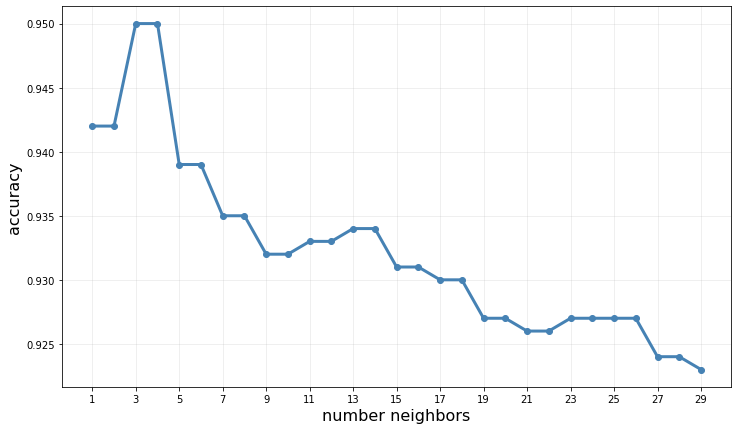

In [12]:
acc = []
allks = range(1,30)

for k in allks:
    knn2 = KNN(data.train_x, data.train_y, k)
    val_yhat = knn2.predict(data.val_x)
    acc.append(accuracy_score(data.val_y, val_yhat))

# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,31,2))
ax.grid(alpha=0.25)

<!-- END QUESTION -->

### Problem 2: Decision Tree, post-pruning and cost complexity parameter using sklearn > 0.22 [50 points]

We will use a pre-processed natural language dataset in the CSV file "spamdata.csv" to classify emails as spam or not. Each row contains the word frequency for 54 words plus statistics on the longest "run" of captial letters.

Word frequency is given by:

$$ f_i = m_i / N $$
Where $f_i$ is the frequency for word $i$, $m_i$ is the number of times word $i$ appears in the email, and $N$ is the total number of words in the email.

We will use decision trees to classify the emails.

**Part 2.A [5 points]:** Complete the function `get_spam_dataset` to read in values from the dataset and split the data into train and test sets.

In [13]:
def get_spam_dataset(filepath="data/spamdata.csv", test_split=0.1):
    '''
    get_spam_dataset
    
    Loads csv file located at "filepath". Shuffles the data and splits
    it so that the you have (1-test_split)*100% training examples and 
    (test_split)*100% testing examples.
    
    Args:
        filepath: location of the csv file
        test_split: percentage/100 of the data should be the testing split
        
    Returns:
        X_train, X_test, y_train, y_test, feature_names
        
        (in that order)
        first four are  np.ndarray
        
    '''
    
    df = pd.read_csv(filepath, sep= ' ')
    feature_names = df.columns
    x = df.iloc[:, :-1].values # All features minus the last column (which is the target labels)
    y = df.iloc[:, -1].values # last column of values. target labels
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=test_split, random_state=25, shuffle= True)
    
    
    return X_train, X_test, y_train, y_test, feature_names


test_split = 0.1 # default test_split; change it if you'd like; ensure that this variable is used as an argument to your function

X_train, X_test, y_train, y_test, label_names = get_spam_dataset(filepath="data/spamdata.csv", test_split=test_split)


**Part 2.B [5 points]** : Build a decision tree classifier using the sklearn toolbox. Then compute metrics for performance like precision and recall. This is a binary classification problem, therefore we can label all points as either positive (SPAM) or negative (NOT SPAM).

In [14]:
def build_dt(data_X, data_y, _max_depth = None, _max_leaf_nodes = None):
    '''
    This function builds the decision tree classifier and 
    fits it to the provided data.
    
    Arguments
        data_X - a np.ndarray
        data_y - np.ndarray
        max_depth - None if unrestricted, otherwise an integer for the maximum
                depth the tree can reach.
    
    Returns:
        A trained DecisionTreeClassifier
    '''
    clf = DecisionTreeClassifier(criterion='gini', max_depth=_max_depth, max_leaf_nodes=_max_leaf_nodes)
    return clf.fit(data_X, data_y)
    
    

<!-- BEGIN QUESTION -->

**Part 2.C [10 pts]**: Here we are going to use `calculate_precision` and `calculate_recall` functions to see how these metrics change when parameters of the tree are changed.

In [15]:
def calculate_precision(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates precision for a binary classifier.
    
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    tp = sum((y_true == 1) & (y_pred == 1))
    fp = sum((y_true == 0) & (y_pred == 1))
    
    prec = tp / (tp +fp)
    return prec


def calculate_recall(y_true, y_pred, pos_label_value=1.0):
    '''
    This function accepts the labels and the predictions, then
    calculates recall for a binary classifier.
    
    Args
        y_true: np.ndarray
        y_pred: np.ndarray
        
        pos_label_value: (float) the number which represents the postiive
        label in the y_true and y_pred arrays. Other numbers will be taken
        to be the non-positive class for the binary classifier.
    
    Returns precision as a floating point number between 0.0 and 1.0
    '''
    tp = sum((y_true == 1) & (y_pred == 1))
    fp = sum((y_true == 0) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))
    
    recall = tp / (tp + fn)
    return recall


In [16]:
# dt3 = build_dt(X_train, y_train)
# y_pred3 = dt3.predict(X_test)

# print("Precision: ",calculate_precision(y_test, y_pred3))
# print("Recall: ", calculate_recall(y_test, y_pred3))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Part 2.D-1 [5 pts]:** Modifying `max_depth`: 
    - Create a model with a shallow `max_depth` of 2. Build the model on the training set.
    - Report precision/recall on the test set.
    - Report depth of the tree.

In [17]:
# TODO : Complete the first subtask for max_depth

dt = build_dt(X_train, y_train, 2)
y_pred = dt.predict(X_test)

precision = calculate_precision(y_test, y_pred)
recall = calculate_recall(y_test, y_pred)

print("Precision: {:0.2f} Recall: {:0.2f} Tree Depth: {}".format(precision, recall, dt.get_depth()))




Precision: 0.92 Recall: 0.70 Tree Depth: 2


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Part 2.D-2 [5 pts]:**  Modifying `max_leaf_nodes`:
    - Create a model with a shallow `max_leaf_nodes` of 4. Build the model on the training set.
    - Report precision/recall on the test set.
    - Report depth of the tree.

In [18]:
# TODO : Complete the second subtask for max_leaf_nodes
dt = build_dt(X_train, y_train, None, 4)
y_pred = dt.predict(X_test)

precision = calculate_precision(y_test, y_pred)
recall = calculate_recall(y_test, y_pred)

print("Precision: {:0.2f} Recall: {:0.2f} No. of leaves: {}".format(precision, recall, dt.get_n_leaves()))




Precision: 0.82 Recall: 0.87 No. of leaves: 4


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Part 2.D-3 [10 pts]:** Answer the following question: <br>
How do precision and recall compare when you modify the max depth compared to the max number of leaf nodes? 
(Make sure to run your models a few times to get an idea). 

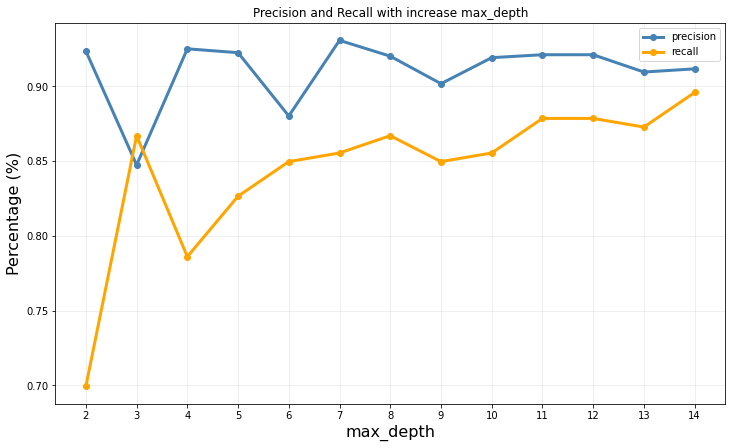

In [19]:
# TODO : Complete the first subtask for max_depth
prec = []
rec = []
all_r = range(2,15)
for i in all_r:
    dt = build_dt(X_train, y_train, i)
    y_pred = dt.predict(X_test)

    precision = calculate_precision(y_test, y_pred)
    recall = calculate_recall(y_test, y_pred)
    prec.append(precision)
    rec.append(recall)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(all_r, prec, marker="o", color="steelblue", lw=3, label="precision")
ax.plot(all_r, rec, marker="o", color="orange", lw=3, label="recall")
ax.set_xlabel("max_depth", fontsize=16)
ax.set_ylabel("Percentage (%)", fontsize=16)
plt.xticks(range(2,15,1))
plt.title("Precision and Recall with increase max_depth")
plt.legend()
ax.grid(alpha=0.25)

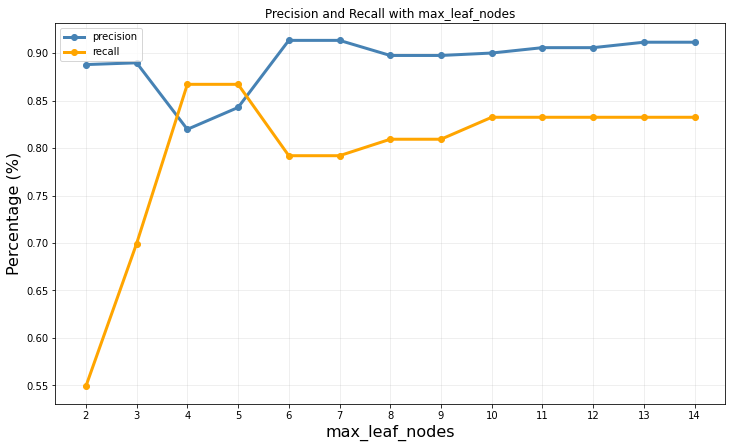

In [20]:
prec = []
rec = []
all_r = range(2,15)
for i in all_r:
    dt = build_dt(X_train, y_train, None, i)
    y_pred = dt.predict(X_test)

    precision = calculate_precision(y_test, y_pred)
    recall = calculate_recall(y_test, y_pred)
    prec.append(precision)
    rec.append(recall)
#     print(precision)
#     print(recall)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(all_r, prec, marker="o", color="steelblue", lw=3, label="precision")
ax.plot(all_r, rec, marker="o", color="orange", lw=3, label="recall")
ax.set_xlabel("max_leaf_nodes", fontsize=16)
ax.set_ylabel("Percentage (%)", fontsize=16)
plt.xticks(range(2,15,1))
plt.title("Precision and Recall with max_leaf_nodes")
plt.legend()
ax.grid(alpha=0.25)

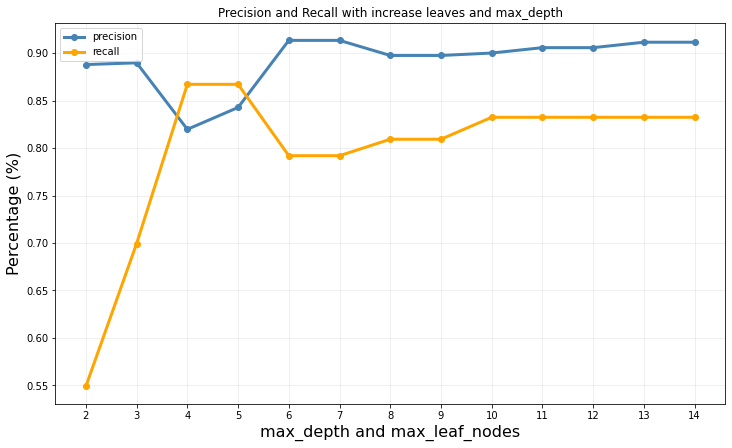

In [21]:
prec = []
rec = []
all_r = range(2,15)
for i in all_r:
    dt = build_dt(X_train, y_train, i, i)
    y_pred = dt.predict(X_test)

    precision = calculate_precision(y_test, y_pred)
    recall = calculate_recall(y_test, y_pred)
    prec.append(precision)
    rec.append(recall)
#     print(precision)
#     print(recall)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(all_r, prec, marker="o", color="steelblue", lw=3, label="precision")
ax.plot(all_r, rec, marker="o", color="orange", lw=3, label="recall")
ax.set_xlabel("max_depth and max_leaf_nodes", fontsize=16)
ax.set_ylabel("Percentage (%)", fontsize=16)
plt.xticks(range(2,15,1))
plt.title("Precision and Recall with increase leaves and max_depth")
plt.legend()
ax.grid(alpha=0.25)

When modifying just the max_depth, the precision and recall value is slight higher than if we were to just adjust the max_leaf_nodes. If we combine the two hyper paremeters together, we get the same values.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Part 2.E [10 pts]** : In class, we used gridsearchCV to do hyperparameter tuning to select the different parameters like `max_depth` to see how our tree grows and avoids overfitting. Here, we will use cost complexity pruning parameter $\alpha$ sklearn 0.22.1[https://scikit-learn.org/stable/user_guide.html] (or a later version) to prune our tree after training so as to improve accuracy on unseen data. In this exercise you will iterate over different `ccp_alpha` values and identify how performance is modulated by this parameter. <br>
**Note:** your code for this section may cause the Validate button to time out. If you want to run the Validate button prior to submitting, you could comment out the code in this section after completing the Peer Review.

Number of nodes in the last tree is: 1 with ccp_alpha: 0.15477458439893277


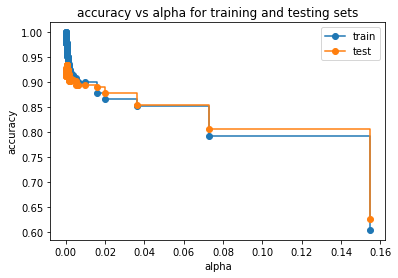

In [22]:
dt = build_dt(X_train, y_train)

path = dt.cost_complexity_pruning_path(X_train,y_train) #post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = [] # VECTOR CONTAINING CLASSIFIERS FOR DIFFERENT ALPHAS
# TODO: iterate over ccp_alpha values 

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)


print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# TODO: next, generate the train and test scores and plot the variation in these scores with increase in ccp_alpha
# The code for plotting has been provided; edit the train_scores and test_scores variables for the right plot to be generated
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]


fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show() 


<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [23]:
grader.check_all()

q1a results: All test cases passed!

q1b results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

These are some submission instructions.

In [24]:
# Save your notebook first, then run this cell to export your submission.
grader.export()